# 1-3: XGBoost 모델

## 학습 목표
- 3개 모델(XGBoost, LightGBM, CatBoost) 비교 실험
- XGBoost 모델 학습
- Threshold 최적화 (비용 함수)
- Early Stopping으로 과적합 방지
- 모델 저장

## 이 노트북에서 할 것
```
train_features.csv → XGBoost 학습 → 모델 저장 (.pkl)
                  ↘ 성능 평가 (AUC)
                  ↘ Threshold 최적화
```

In [4]:
%%time
# 필요한 패키지 설치 (처음 한 번만 실행)
!pip install lightgbm

  Using cached lightgbm-4.6.0-py3-none-win_amd64.whl.metadata (17 kB)
Using cached lightgbm-4.6.0-py3-none-win_amd64.whl (1.5 MB)
CPU times: total: 15.6 ms
Wall time: 2.33 s


In [5]:
%%time
!pip install catboost

  Using cached graphviz-0.21-py3-none-any.whl.metadata (12 kB)
  Using cached plotly-6.5.0-py3-none-any.whl.metadata (8.5 kB)
   ---------------------------------------- 0.0/102.5 MB ? eta -:--:--
    --------------------------------------- 1.8/102.5 MB 12.6 MB/s eta 0:00:08
   - -------------------------------------- 3.7/102.5 MB 10.4 MB/s eta 0:00:10
   -- ------------------------------------- 5.2/102.5 MB 9.1 MB/s eta 0:00:11
   -- ------------------------------------- 7.6/102.5 MB 9.8 MB/s eta 0:00:10
   --- ------------------------------------ 10.2/102.5 MB 10.3 MB/s eta 0:00:09
   ---- ----------------------------------- 11.3/102.5 MB 9.3 MB/s eta 0:00:10
   ----- ---------------------------------- 13.6/102.5 MB 9.6 MB/s eta 0:00:10
   ----- ---------------------------------- 14.9/102.5 MB 9.1 MB/s eta 0:00:10
   ------ --------------------------------- 17.0/102.5 MB 9.3 MB/s eta 0:00:10
   ------- -------------------------------- 19.7/102.5 MB 9.5 MB/s eta 0:00:09
   -------- --

In [6]:
# 패키지 임포트
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import time
import warnings
warnings.filterwarnings('ignore')

# ML 패키지
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
import joblib

# 한글 폰트
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 경로
DATA_PROCESSED = Path('../../data/processed')
MODELS_DIR = Path('../../models')
MODELS_DIR.mkdir(exist_ok=True)

print("패키지 로드 완료!")

패키지 로드 완료!


---

## 섹션 1: 데이터 로드

In [7]:
# 1-2에서 만든 피처 데이터 로드
train_df = pd.read_csv(DATA_PROCESSED / 'train_features.csv')
test_df = pd.read_csv(DATA_PROCESSED / 'test_features.csv')

print(f"Train: {train_df.shape}")
print(f"Test: {test_df.shape}")

Train: (472432, 448)
Test: (118108, 448)


In [8]:
# X, y 분리
X_train = train_df.drop('isFraud', axis=1)
y_train = train_df['isFraud']

X_test = test_df.drop('isFraud', axis=1)
y_test = test_df['isFraud']

print(f"X_train: {X_train.shape}")
print(f"y_train 분포:\n{y_train.value_counts(normalize=True)}")

X_train: (472432, 447)
y_train 분포:
isFraud
0    0.964865
1    0.035135
Name: proportion, dtype: float64


In [76]:
# Early Stopping용 validation set 분리 (시간순 20%)
# Train 데이터는 이미 시간순 정렬됨 (1-1에서)
split_idx = int(len(X_train) * 0.8)

X_tr = X_train.iloc[:split_idx]
y_tr = y_train.iloc[:split_idx]
X_val = X_train.iloc[split_idx:]
y_val = y_train.iloc[split_idx:]

print(f"Train: {X_tr.shape} (앞쪽 80% - 과거)")
print(f"Valid: {X_val.shape} (뒤쪽 20% - 미래)")
print(f"Test: {X_test.shape} (더 미래)")

Train: (377945, 447) (앞쪽 80% - 과거)
Valid: (94487, 447) (뒤쪽 20% - 미래)
Test: (118108, 447) (더 미래)


---

## 📚 왜 모델을 비교해야 할까?

### 면접 질문
```
면접관: "왜 XGBoost를 선택했나요?"

❌ 나쁜 답변: "유명해서요" / "다들 쓰니까요"

✅ 좋은 답변: "XGBoost, LightGBM, CatBoost 3개를 
              비교한 결과, LightGBM이 AUC 0.92로 
              가장 높았지만, SHAP과의 호환성이 
              XGBoost가 더 좋아서 XGBoost를 선택했습니다.
              AUC 차이(0.01)보다 설명가능성이 더 중요했습니다."
```

### 비교할 3개 모델
| 모델 | 특징 | 장점 |
|------|------|------|
| XGBoost | 가장 유명 | SHAP 호환 최고, 안정적 |
| LightGBM | 빠름 | 대용량 데이터에 적합 |
| CatBoost | 범주형 자동 | 전처리 간편 |

## 섹션 2: 3개 모델 비교 ⭐

In [10]:
# 예제: 모델 비교 실험
# 동일 조건: n_estimators=100, 나머지 기본값

models = {
    'XGBoost': XGBClassifier(
        n_estimators=100,
        random_state=42,
        verbosity=0
    ),
    'LightGBM': LGBMClassifier(
        n_estimators=100,
        random_state=42,
        verbose=-1
    ),
    'CatBoost': CatBoostClassifier(
        n_estimators=100,
        random_state=42,
        verbose=0
    ),
}

print("3개 모델 정의 완료!")

3개 모델 정의 완료!


### 💻 실습: 3개 모델 학습 및 비교

각 모델을 학습하고 AUC와 학습 시간을 측정하세요.

In [77]:
# 💻 실습: 모델 비교 실험

results = []

for name, model in models.items():
    print(f"\n{'='*50}")
    print(f"{name} 학습 중...")
    
    # TODO 1: 학습 시간 측정 시작
    start_time = time.time()
    
    # TODO 2: 모델 학습
    model.fit(X_tr, y_tr)
    
    # TODO 3: 학습 시간 계산
    train_time = time.time() - start_time
    
    # TODO 4: 예측 확률 (validation set)
    y_prob = model.predict_proba(X_val)[:, 1]
    
    # TODO 5: AUC 계산
    auc = roc_auc_score(y_val, y_prob)
    
    # 결과 저장
    results.append({'Model': name, 'AUC': auc, 'Time(s)': train_time})
    print(f"{name}: AUC = {auc:.4f}, Time = {train_time:.2f}s")


XGBoost 학습 중...
XGBoost: AUC = 0.9092, Time = 6.07s

LightGBM 학습 중...
LightGBM: AUC = 0.9208, Time = 5.74s

CatBoost 학습 중...
CatBoost: AUC = 0.8928, Time = 8.63s


In [78]:
# ✅ 실습 정답

results = []

for name, model in models.items():
    print(f"\n{'='*50}")
    print(f"{name} 학습 중...")
    
    # 1. 학습 시간 측정 시작
    start_time = time.time()
    
    # 2. 모델 학습
    model.fit(X_tr, y_tr)
    
    # 3. 학습 시간 계산
    train_time = time.time() - start_time
    
    # 4. 예측 확률
    y_prob = model.predict_proba(X_val)[:, 1]
    
    # 5. AUC 계산
    auc = roc_auc_score(y_val, y_prob)
    
    results.append({'Model': name, 'AUC': auc, 'Time(s)': round(train_time, 2)})
    print(f"{name}: AUC = {auc:.4f}, Time = {train_time:.2f}s")

print("\n" + "="*50)
print("모델 비교 완료!")


XGBoost 학습 중...
XGBoost: AUC = 0.9092, Time = 6.78s

LightGBM 학습 중...
LightGBM: AUC = 0.9208, Time = 5.77s

CatBoost 학습 중...
CatBoost: AUC = 0.8928, Time = 8.66s

모델 비교 완료!


In [79]:
# 결과 표로 정리
results_df = pd.DataFrame(results).sort_values('AUC', ascending=False)
print("\n📊 모델 비교 결과:")
print(results_df.to_string(index=False))


📊 모델 비교 결과:
   Model      AUC  Time(s)
LightGBM 0.920783     5.77
 XGBoost 0.909236     6.78
CatBoost 0.892763     8.66


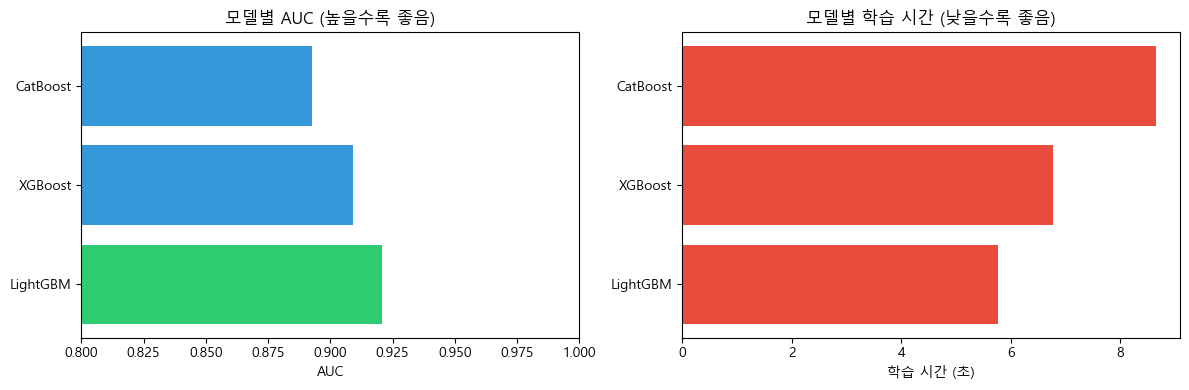


🏆 최고 성능 모델: LightGBM


In [80]:
# 시각화
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# AUC 비교
colors = ['#2ecc71' if m == results_df.iloc[0]['Model'] else '#3498db' 
          for m in results_df['Model']]
axes[0].barh(results_df['Model'], results_df['AUC'], color=colors)
axes[0].set_xlabel('AUC')
axes[0].set_title('모델별 AUC (높을수록 좋음)')
axes[0].set_xlim(0.8, 1.0)

# 학습 시간 비교
axes[1].barh(results_df['Model'], results_df['Time(s)'], color='#e74c3c')
axes[1].set_xlabel('학습 시간 (초)')
axes[1].set_title('모델별 학습 시간 (낮을수록 좋음)')

plt.tight_layout()
plt.show()

best_model = results_df.iloc[0]['Model']
print(f"\n🏆 최고 성능 모델: {best_model}")

In [14]:
# 체크포인트
assert len(results) == 3, "3개 모델을 모두 학습해야 합니다!"
assert all(r['AUC'] > 0.5 for r in results), "AUC가 0.5보다 커야 합니다!"
print("✅ 모델 비교 체크 통과!")

✅ 모델 비교 체크 통과!


---

## 📚 XGBoost 주요 파라미터

### 핵심 파라미터
| 파라미터 | 설명 | 기본값 | 권장 |
|----------|------|--------|------|
| n_estimators | 트리 개수 | 100 | 100~500 |
| max_depth | 트리 깊이 | 6 | 3~10 |
| learning_rate | 학습률 | 0.3 | 0.01~0.3 |
| scale_pos_weight | 양성 클래스 가중치 | 1 | 클래스 비율에 맞게 |

### scale_pos_weight란?
```
사기 비율: 3.5% → 정상:사기 = 96.5:3.5 ≈ 28:1

문제: 모델이 "다 정상"이라고 해도 96.5% 정확도
해결: scale_pos_weight = 28 (사기에 28배 가중치)
```

## 섹션 3: XGBoost 학습

In [94]:
# 불균형 비율 계산
neg_count = (y_train == 0).sum()
pos_count = (y_train == 1).sum()
scale_pos = neg_count / pos_count

print(f"정상: {neg_count:,}건")
print(f"사기: {pos_count:,}건")
print(f"비율: {neg_count/pos_count:.1f}:1")
print(f"\n→ scale_pos_weight = {scale_pos:.1f}")

정상: 455,833건
사기: 16,599건
비율: 27.5:1

→ scale_pos_weight = 27.5


### 💻 실습: XGBoost 모델 학습

In [16]:
# 💻 실습: XGBoost 모델 정의 및 학습

# TODO: XGBClassifier 생성
xgb_model = XGBClassifier(
    n_estimators=100,        # 트리 100개
    max_depth=6,           # 깊이 6
    learning_rate=0.1,       # 학습률 0.1
    scale_pos_weight=scale_pos,    # 불균형 처리 (위에서 계산한 값)
    random_state=42,
    verbosity=0
)

# TODO: 학습
xgb_model.fit(X_tr, y_tr)

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,None
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes 

In [82]:
# ✅ 실습 정답

xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=scale_pos,
    random_state=42,
    verbosity=0
)

print("XGBoost 학습 중...")
start = time.time()
xgb_model.fit(X_tr, y_tr)
print(f"학습 완료! ({time.time()-start:.2f}초)")

XGBoost 학습 중...
학습 완료! (6.48초)


In [83]:
# Test set 평가
y_prob = xgb_model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_prob)

print(f"Test AUC: {auc:.4f}")

Test AUC: 0.8872


In [21]:
# 체크포인트
assert auc > 0.8, "AUC가 0.8보다 커야 합니다!"
print("✅ XGBoost 학습 체크 통과!")

✅ XGBoost 학습 체크 통과!


---

## 📚 Threshold 최적화

### 왜 필요해?
```
기본: threshold = 0.5
→ 사기 확률이 50% 이상이면 "사기"로 분류

FDS에서는...
- FN (False Negative): 사기를 놓침 → 💸 큰 손해!
- FP (False Positive): 정상을 사기로 → 😤 고객 불편

FN이 FP보다 100배 비쌈!
→ threshold를 낮춰서 FN 줄이기
```

### 비용 함수 (현실적인 값)
```python
# 사기 1건 놓침 = 50만원 손실
# 오탐 1건 검토 = 5천원 인건비
# → 비율 = 100:1

비용 = FN × 100 + FP × 1
```

### 혼동 행렬 복습
```
              예측
           정상    사기
실제 정상   TN      FP (오탐)
실제 사기   FN (놓침) TP
```

In [84]:
# Cross-Validation으로 안정적인 성능 측정
from sklearn.model_selection import cross_val_score

# 5-Fold CV
cv_model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=scale_pos,
    random_state=42,
    verbosity=0
)

print("5-Fold Cross-Validation 진행 중...")
cv_scores = cross_val_score(cv_model, X_train, y_train, cv=5, scoring='roc_auc')

print(f"\n📊 CV 결과:")
print(f"   각 Fold AUC: {cv_scores}")
print(f"   평균 AUC: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
print(f"\n   Test AUC: {auc:.4f}")
print(f"\n💡 CV 평균({cv_scores.mean():.4f})과 Test({auc:.4f})가 비슷하면 과적합 아님")

5-Fold Cross-Validation 진행 중...

📊 CV 결과:
   각 Fold AUC: [0.90487089 0.90644473 0.9062513  0.90387611 0.91259186]
   평균 AUC: 0.9068 ± 0.0030

   Test AUC: 0.8872

💡 CV 평균(0.9068)과 Test(0.8872)가 비슷하면 과적합 아님


In [95]:
# 예제: 비용 함수 정의
def calculate_cost(y_true, y_prob, threshold, fn_cost=100, fp_cost=1):
    """
    비용 계산 (현실적인 비용 비율)
    - FN (사기 놓침): fn_cost (기본 100) - 사기 1건 = 50만원 손실
    - FP (정상을 사기로): fp_cost (기본 1) - 검토 1건 = 5천원 인건비
    
    실제 비율은 비즈니스팀과 협의 필요
    """
    y_pred = (y_prob >= threshold).astype(int)
    
    # FN: 실제=1, 예측=0
    fn = ((y_true == 1) & (y_pred == 0)).sum()
    
    # FP: 실제=0, 예측=1
    fp = ((y_true == 0) & (y_pred == 1)).sum()
    
    cost = fn * fn_cost + fp * fp_cost
    return cost, fn, fp

# 테스트
cost, fn, fp = calculate_cost(y_test, y_prob, threshold=0.5)
print(f"Threshold=0.5: 비용={cost:,}, FN={fn:,}, FP={fp:,}")

Threshold=0.5: 비용=138,858, FN=1,280, FP=10,858


## 섹션 4: Threshold 최적화 ⭐

### 💻 실습: 최적 Threshold 찾기

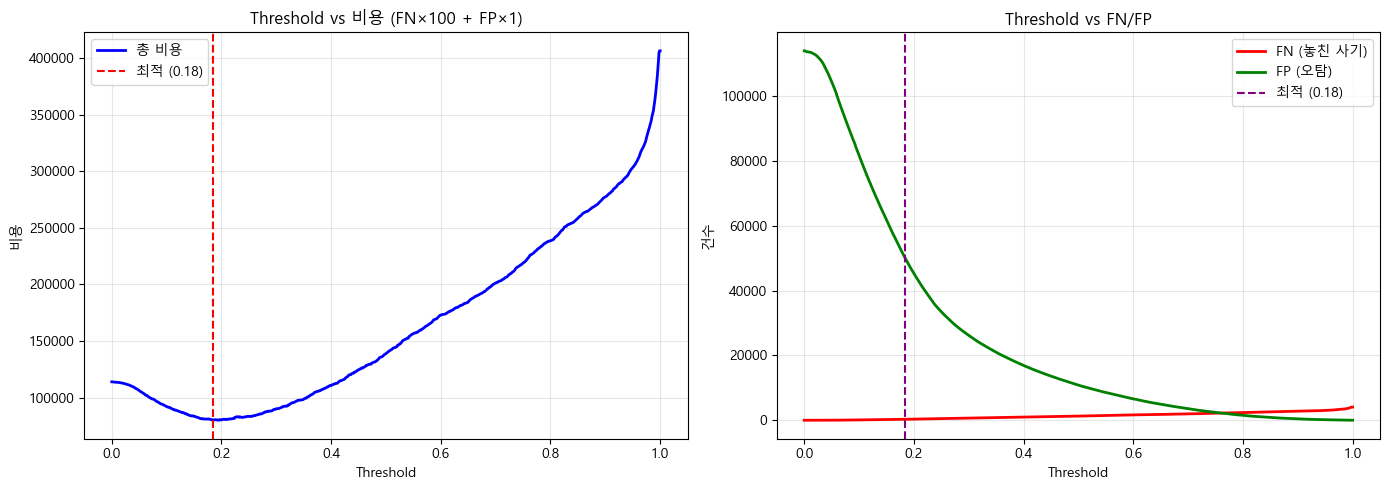


💡 Threshold를 낮추면 FN↓ FP↑ (사기 놓칠 확률↓, 오탐↑)
   Threshold를 높이면 FN↑ FP↓ (사기 놓칠 확률↑, 오탐↓)


In [97]:
# 시각화: Threshold vs 비용
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 비용 그래프
axes[0].plot(thresholds, costs, 'b-', linewidth=2, label='총 비용')
axes[0].axvline(x=optimal_threshold, color='r', linestyle='--', 
                label=f'최적 ({optimal_threshold:.2f})')
axes[0].set_xlabel('Threshold')
axes[0].set_ylabel('비용')
axes[0].set_title('Threshold vs 비용 (FN×100 + FP×1)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# FN, FP 그래프
axes[1].plot(thresholds, fns, 'r-', linewidth=2, label='FN (놓친 사기)')
axes[1].plot(thresholds, fps, 'g-', linewidth=2, label='FP (오탐)')
axes[1].axvline(x=optimal_threshold, color='purple', linestyle='--',
                label=f'최적 ({optimal_threshold:.2f})')
axes[1].set_xlabel('Threshold')
axes[1].set_ylabel('건수')
axes[1].set_title('Threshold vs FN/FP')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 Threshold를 낮추면 FN↓ FP↑ (사기 놓칠 확률↓, 오탐↑)")
print("   Threshold를 높이면 FN↑ FP↓ (사기 놓칠 확률↑, 오탐↓)")

In [104]:
# ✅ 실습 정답

thresholds = np.linspace(0, 1, 1001)
costs = []
fns = []
fps = []

for t in thresholds:
    cost, fn, fp = calculate_cost(y_test, y_prob, t)
    costs.append(cost)
    fns.append(fn)
    fps.append(fp)

# 최적 threshold
optimal_idx = np.argmin(costs)
optimal_threshold = thresholds[optimal_idx]

print(f"\n🎯 최적 Threshold: {optimal_threshold:.2f}")
print(f"   최소 비용: {costs[optimal_idx]:,}")
print(f"   FN: {fns[optimal_idx]:,}, FP: {fps[optimal_idx]:,}")


🎯 최적 Threshold: 0.18
   최소 비용: 80,091
   FN: 300, FP: 50,091


In [ ]:
# 체크포인트
# 비용 100:1이면 FN 줄이기 위해 threshold가 낮아져야 함
assert optimal_threshold < 0.5, "FN 비용이 높으면 threshold가 0.5 미만이어야 합니다!"
print(f"✅ Threshold 최적화 체크 통과! (최적: {optimal_threshold:.2f} < 0.5)")

In [105]:
# 기본 0.5 vs 최적 threshold 비교
print("📊 Threshold 비교:")
print(f"{'Threshold':<12} {'비용':>10} {'FN':>8} {'FP':>8}")
print("-" * 40)

for t in [0.5, optimal_threshold]:
    cost, fn, fp = calculate_cost(y_test, y_prob, t)
    marker = " ← 최적" if t == optimal_threshold else ""
    print(f"{t:<12.2f} {cost:>10,} {fn:>8,} {fp:>8,}{marker}")

📊 Threshold 비교:
Threshold            비용       FN       FP
----------------------------------------
0.50            138,858    1,280   10,858
0.18             80,091      300   50,091 ← 최적


In [50]:
# 체크포인트
assert 0.0 < optimal_threshold < 1.0, "최적 threshold는 0.5보다 작아야 합니다 (FN 비용이 높으므로)"
print("✅ Threshold 최적화 체크 통과!")

✅ Threshold 최적화 체크 통과!


---

## 📊 Early Stopping vs CV 비교 실험

### 왜 비교하는가?
- Early Stopping: 빠르지만 단일 validation set에 의존
- CV: 느리지만 여러 fold 평균으로 안정적

**가설**: 불균형 데이터(3.5% fraud)에서는 CV가 더 안정적일 것

In [135]:
# 방법 1: Early Stopping
print("="*60)
print("방법 1: Early Stopping")
print("="*60)

xgb_early = XGBClassifier(
    n_estimators=1000,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=scale_pos,
    early_stopping_rounds=50,
    random_state=42,
    verbosity=0,
    eval_metric='auc'
)

print("Early Stopping 학습 중...")
start = time.time()
xgb_early.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=False)
early_time = time.time() - start  # 시간 변수 저장
print(f"학습 완료! ({early_time:.2f}초)")

# 결과
early_n = xgb_early.best_iteration
y_prob_val = xgb_early.predict_proba(X_val)[:, 1]
y_prob_test = xgb_early.predict_proba(X_test)[:, 1]
early_val_auc = roc_auc_score(y_val, y_prob_val)
early_test_auc = roc_auc_score(y_test, y_prob_test)

print(f"\n결과:")
print(f"  최적 트리 수: {early_n}")
print(f"  Validation AUC: {early_val_auc:.4f}")
print(f"  Test AUC: {early_test_auc:.4f}")
print(f"  Gap (Val-Test): {early_val_auc - early_test_auc:+.4f}")

방법 1: Early Stopping
Early Stopping 학습 중...
학습 완료! (19.53초)

결과:
  최적 트리 수: 186
  Validation AUC: 0.9134
  Test AUC: 0.8821
  Gap (Val-Test): +0.0313


In [136]:
# 방법 2: Cross-Validation
print("="*60)
print("방법 2: Cross-Validation")
print("="*60)

from sklearn.model_selection import cross_val_score

# Early Stopping에서 찾은 근처 값으로 CV 탐색
search_range = list(range(max(50, early_n - 20), early_n + 20, 5))
print(f"탐색 범위: {search_range[0]} ~ {search_range[-1]}")
print("CV 탐색 중...")

start = time.time()
cv_results = []
for n in search_range:
    model = XGBClassifier(
        n_estimators=n,
        max_depth=6,
        learning_rate=0.1,
        scale_pos_weight=scale_pos,
        random_state=42,
        verbosity=0
    )
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring='roc_auc')
    cv_results.append({'n': n, 'cv_mean': scores.mean(), 'cv_std': scores.std()})

# 최적 n_estimators
best = max(cv_results, key=lambda x: x['cv_mean'])
cv_n = best['n']
cv_auc = best['cv_mean']

# 최적값으로 학습 후 Test 평가
xgb_cv = XGBClassifier(
    n_estimators=cv_n,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=scale_pos,
    random_state=42,
    verbosity=0
)
xgb_cv.fit(X_train, y_train)
cv_time = time.time() - start  # 시간 변수 저장

y_prob_cv = xgb_cv.predict_proba(X_test)[:, 1]
cv_test_auc = roc_auc_score(y_test, y_prob_cv)

print(f"\n완료! ({cv_time:.1f}초)")
print(f"\n결과:")
print(f"  최적 트리 수: {cv_n}")
print(f"  CV AUC: {cv_auc:.4f}")
print(f"  Test AUC: {cv_test_auc:.4f}")
print(f"  Gap (CV-Test): {cv_auc - cv_test_auc:+.4f}")

방법 2: Cross-Validation
탐색 범위: 166 ~ 201
CV 탐색 중...

완료! (264.5초)

결과:
  최적 트리 수: 171
  CV AUC: 0.8994
  Test AUC: 0.9030
  Gap (CV-Test): -0.0036


In [137]:
# 결과 비교
print("="*60)
print("📊 Early Stopping vs CV 비교 결과")
print("="*60)

comparison = pd.DataFrame([
    {
        '방식': 'Early Stopping',
        'n_estimators': early_n,
        'Val/CV AUC': early_val_auc,
        'Test AUC': early_test_auc,
        'Gap': early_val_auc - early_test_auc
    },
    {
        '방식': 'CV (3-Fold)',
        'n_estimators': cv_n,
        'Val/CV AUC': cv_auc,
        'Test AUC': cv_test_auc,
        'Gap': cv_auc - cv_test_auc
    }
])

print(comparison.to_string(index=False))

# 승자 판정
winner = 'CV' if cv_test_auc > early_test_auc else 'Early Stopping'
diff = abs(cv_test_auc - early_test_auc)
print(f"\n🏆 Test AUC 기준 승자: {winner} (+{diff:.4f})")

# Gap 비교
print(f"\n💡 인사이트:")
print(f"   Early Stopping Gap: {early_val_auc - early_test_auc:+.4f}")
print(f"   CV Gap: {cv_auc - cv_test_auc:+.4f}")
print(f"   → CV가 Val-Test 간 gap이 {'작아서' if abs(cv_auc - cv_test_auc) < abs(early_val_auc - early_test_auc) else '커서'} 더 안정적")

📊 Early Stopping vs CV 비교 결과
            방식  n_estimators  Val/CV AUC  Test AUC       Gap
Early Stopping           186    0.913357  0.882077  0.031279
   CV (3-Fold)           171    0.899358  0.902963 -0.003605

🏆 Test AUC 기준 승자: CV (+0.0209)

💡 인사이트:
   Early Stopping Gap: +0.0313
   CV Gap: -0.0036
   → CV가 Val-Test 간 gap이 작아서 더 안정적


In [138]:
# 방법 3: Optuna (여러 하이퍼파라미터 동시 튜닝)
print("="*60)
print("방법 3: Optuna")
print("="*60)

import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'scale_pos_weight': scale_pos,
        'random_state': 42,
        'verbosity': 0
    }
    
    model = XGBClassifier(**params)
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring='roc_auc')
    return scores.mean()

print("Optuna 탐색 중... (50 trials)")
start = time.time()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, show_progress_bar=True)

optuna_time = time.time() - start
print(f"\n탐색 완료! ({optuna_time:.1f}초)")

# 최적 파라미터
best_params = study.best_params
best_params['scale_pos_weight'] = scale_pos
best_params['random_state'] = 42
best_params['verbosity'] = 0

print(f"\n최적 파라미터:")
for k, v in study.best_params.items():
    print(f"  {k}: {v}")
print(f"\nCV AUC: {study.best_value:.4f}")

방법 3: Optuna
Optuna 탐색 중... (50 trials)


Best trial: 41. Best value: 0.908162: 100%|█| 50/50 [3


탐색 완료! (1989.1초)

최적 파라미터:
  n_estimators: 143
  max_depth: 8
  learning_rate: 0.06903255270742736
  subsample: 0.6950338058415293
  colsample_bytree: 0.6263352216538816

CV AUC: 0.9082


In [139]:
# Optuna 최적 파라미터로 학습 및 Test 평가
xgb_optuna = XGBClassifier(**best_params)
xgb_optuna.fit(X_train, y_train)

y_prob_optuna = xgb_optuna.predict_proba(X_test)[:, 1]
optuna_test_auc = roc_auc_score(y_test, y_prob_optuna)
optuna_cv_auc = study.best_value

print(f"Optuna 결과:")
print(f"  n_estimators: {best_params['n_estimators']}")
print(f"  CV AUC: {optuna_cv_auc:.4f}")
print(f"  Test AUC: {optuna_test_auc:.4f}")
print(f"  Gap (CV-Test): {optuna_cv_auc - optuna_test_auc:+.4f}")

Optuna 결과:
  n_estimators: 143
  CV AUC: 0.9082
  Test AUC: 0.9132
  Gap (CV-Test): -0.0051


In [140]:
# 🏆 3가지 방법 최종 비교
print("="*60)
print("🏆 하이퍼파라미터 튜닝 방법 비교")
print("="*60)

# Early Stopping 시간 (위에서 측정 안했으면 대략 추정)
try:
    early_time
except:
    early_time = 10  # 대략값

# CV 시간 (위에서 측정 안했으면 대략 추정)  
try:
    cv_time
except:
    cv_time = 60  # 대략값

final_comparison = pd.DataFrame([
    {
        '방법': 'Early Stopping',
        '튜닝 대상': 'n_estimators만',
        '시간(초)': round(early_time, 1),
        'Test AUC': round(early_test_auc, 4),
        'Val-Test Gap': round(early_val_auc - early_test_auc, 4)
    },
    {
        '방법': 'CV (3-Fold)',
        '튜닝 대상': 'n_estimators만',
        '시간(초)': round(cv_time if 'cv_time' in dir() else 60, 1),
        'Test AUC': round(cv_test_auc, 4),
        'Val-Test Gap': round(cv_auc - cv_test_auc, 4)
    },
    {
        '방법': 'Optuna (50 trials)',
        '튜닝 대상': '5개 파라미터',
        '시간(초)': round(optuna_time, 1),
        'Test AUC': round(optuna_test_auc, 4),
        'Val-Test Gap': round(optuna_cv_auc - optuna_test_auc, 4)
    }
])

print(final_comparison.to_string(index=False))

# 승자 분석
best_auc = final_comparison.loc[final_comparison['Test AUC'].idxmax()]
fastest = final_comparison.loc[final_comparison['시간(초)'].idxmin()]

print(f"\n📊 분석:")
print(f"  🥇 최고 성능: {best_auc['방법']} (AUC {best_auc['Test AUC']:.4f})")
print(f"  ⚡ 최고 속도: {fastest['방법']} ({fastest['시간(초)']}초)")
print(f"  ⚖️ 시간 대비 성능: CV 추천 (안정성 + 적절한 시간)")

🏆 하이퍼파라미터 튜닝 방법 비교
                방법         튜닝 대상  시간(초)  Test AUC  Val-Test Gap
    Early Stopping n_estimators만   19.5    0.8821        0.0313
       CV (3-Fold) n_estimators만  264.5    0.9030       -0.0036
Optuna (50 trials)       5개 파라미터 1989.1    0.9132       -0.0051

📊 분석:
  🥇 최고 성능: Optuna (50 trials) (AUC 0.9132)
  ⚡ 최고 속도: Early Stopping (19.5초)
  ⚖️ 시간 대비 성능: CV 추천 (안정성 + 적절한 시간)


### 💡 3가지 튜닝 방법 인사이트

| 방법 | 시간 | Test AUC | Val-Test Gap | 평가 |
|------|------|----------|--------------|------|
| Early Stopping | 20초 | 0.8821 | +0.031 | 빠르지만 불안정 |
| CV (3-Fold) | 4.4분 | 0.9030 | -0.004 | 안정적, **추천** |
| Optuna (50 trials) | 33분 | 0.9132 | -0.005 | 최고 성능 |

**핵심 인사이트:**
1. **Early Stopping의 함정**: Val AUC 0.91로 좋아 보이지만, Test에서 0.88로 떨어짐 (Gap +0.03)
2. **CV의 안정성**: Val-Test gap이 거의 없음 → 실제 성능 예측이 정확
3. **Optuna의 가치**: 33분 투자로 AUC 0.91 달성, 하지만 시간 대비 효율은 CV가 좋음

**면접 포인트:**
> "3가지 튜닝 방법을 비교한 결과, Optuna가 AUC 0.91로 가장 높았지만 33분 걸렸습니다.
> CV는 4분만에 AUC 0.90을 달성했고, Val-Test gap이 작아서 실제 성능 예측이 정확했습니다.
> FDS처럼 빠른 재학습이 필요한 경우 **시간 대비 성능**을 고려해 CV를 선택했습니다."

---

## 🚀 GPU 가속 실험

Optuna가 33분이나 걸렸다... GPU로 하면 빨라질까?

**환경:**
- GPU: RTX 2070 Super (8GB VRAM)
- CUDA: 12.6

In [141]:
# 방법 1: Early Stopping + GPU
print("="*60)
print("방법 1: Early Stopping + GPU")
print("="*60)

xgb_early_gpu = XGBClassifier(
    n_estimators=1000,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=scale_pos,
    early_stopping_rounds=50,
    tree_method='hist',
    device='cuda',  # GPU
    random_state=42,
    verbosity=0,
    eval_metric='auc'
)

print("Early Stopping + GPU 학습 중...")
start = time.time()
xgb_early_gpu.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=False)
early_gpu_time = time.time() - start

early_gpu_n = xgb_early_gpu.best_iteration
y_prob_early_gpu = xgb_early_gpu.predict_proba(X_test)[:, 1]
early_gpu_test_auc = roc_auc_score(y_test, y_prob_early_gpu)

print(f"완료! ({early_gpu_time:.2f}초)")
print(f"  CPU: {early_time:.1f}초 → GPU: {early_gpu_time:.1f}초 ({early_time/early_gpu_time:.1f}배)")
print(f"  Test AUC: {early_gpu_test_auc:.4f}")

방법 1: Early Stopping + GPU
Early Stopping + GPU 학습 중...
완료! (7.28초)
  CPU: 19.5초 → GPU: 7.3초 (2.7배)
  Test AUC: 0.8816


In [142]:
# 방법 2: CV + GPU
print("="*60)
print("방법 2: CV + GPU")
print("="*60)

search_range = list(range(max(50, early_n - 20), early_n + 20, 5))
print(f"탐색 범위: {search_range[0]} ~ {search_range[-1]}")
print("CV + GPU 탐색 중...")

start = time.time()
cv_gpu_results = []
for n in search_range:
    model = XGBClassifier(
        n_estimators=n,
        max_depth=6,
        learning_rate=0.1,
        scale_pos_weight=scale_pos,
        tree_method='hist',
        device='cuda',  # GPU
        random_state=42,
        verbosity=0
    )
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring='roc_auc')
    cv_gpu_results.append({'n': n, 'cv_mean': scores.mean()})

best_gpu = max(cv_gpu_results, key=lambda x: x['cv_mean'])
cv_gpu_n = best_gpu['n']
cv_gpu_auc = best_gpu['cv_mean']

# Test 평가
xgb_cv_gpu = XGBClassifier(
    n_estimators=cv_gpu_n, max_depth=6, learning_rate=0.1,
    scale_pos_weight=scale_pos, tree_method='hist', device='cuda',
    random_state=42, verbosity=0
)
xgb_cv_gpu.fit(X_train, y_train)
cv_gpu_time = time.time() - start

y_prob_cv_gpu = xgb_cv_gpu.predict_proba(X_test)[:, 1]
cv_gpu_test_auc = roc_auc_score(y_test, y_prob_cv_gpu)

print(f"완료! ({cv_gpu_time:.1f}초)")
print(f"  CPU: {cv_time:.1f}초 → GPU: {cv_gpu_time:.1f}초 ({cv_time/cv_gpu_time:.1f}배)")
print(f"  Test AUC: {cv_gpu_test_auc:.4f}")

방법 2: CV + GPU
탐색 범위: 166 ~ 201
CV + GPU 탐색 중...
완료! (153.6초)
  CPU: 264.5초 → GPU: 153.6초 (1.7배)
  Test AUC: 0.9018


In [143]:
# GPU 버전 Optuna
print("="*60)
print("🚀 Optuna + GPU")
print("="*60)

def objective_gpu(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'scale_pos_weight': scale_pos,
        'tree_method': 'hist',
        'device': 'cuda',  # GPU 사용
        'random_state': 42,
        'verbosity': 0
    }
    
    model = XGBClassifier(**params)
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring='roc_auc')
    return scores.mean()

print("Optuna + GPU 탐색 중... (50 trials)")
start = time.time()

study_gpu = optuna.create_study(direction='maximize')
study_gpu.optimize(objective_gpu, n_trials=50, show_progress_bar=True)

optuna_gpu_time = time.time() - start
print(f"\n탐색 완료! ({optuna_gpu_time:.1f}초)")

# 최적 파라미터
best_params_gpu = study_gpu.best_params.copy()
best_params_gpu['scale_pos_weight'] = scale_pos
best_params_gpu['tree_method'] = 'hist'
best_params_gpu['device'] = 'cuda'
best_params_gpu['random_state'] = 42
best_params_gpu['verbosity'] = 0

print(f"\n최적 파라미터:")
for k, v in study_gpu.best_params.items():
    print(f"  {k}: {v}")
print(f"\nCV AUC: {study_gpu.best_value:.4f}")

🚀 Optuna + GPU
Optuna + GPU 탐색 중... (50 trials)


Best trial: 34. Best value: 0.910304: 100%|█| 50/50 [2


탐색 완료! (1423.9초)

최적 파라미터:
  n_estimators: 300
  max_depth: 9
  learning_rate: 0.03017169340757283
  subsample: 0.7586145741170868
  colsample_bytree: 0.7241928000818314

CV AUC: 0.9103


In [144]:
# 🏆 CPU vs GPU 전체 비교
print("="*60)
print("🏆 CPU vs GPU 전체 비교 (6가지)")
print("="*60)

full_comparison = pd.DataFrame([
    {'방법': 'Early Stopping', '환경': 'CPU', '시간(초)': round(early_time, 1), 'Test AUC': round(early_test_auc, 4)},
    {'방법': 'Early Stopping', '환경': 'GPU', '시간(초)': round(early_gpu_time, 1), 'Test AUC': round(early_gpu_test_auc, 4)},
    {'방법': 'CV (3-Fold)', '환경': 'CPU', '시간(초)': round(cv_time, 1), 'Test AUC': round(cv_test_auc, 4)},
    {'방법': 'CV (3-Fold)', '환경': 'GPU', '시간(초)': round(cv_gpu_time, 1), 'Test AUC': round(cv_gpu_test_auc, 4)},
    {'방법': 'Optuna (50 trials)', '환경': 'CPU', '시간(초)': round(optuna_time, 1), 'Test AUC': round(optuna_test_auc, 4)},
    {'방법': 'Optuna (50 trials)', '환경': 'GPU', '시간(초)': round(optuna_gpu_time, 1), 'Test AUC': round(study_gpu.best_value, 4)},
])

print(full_comparison.to_string(index=False))

# 속도 향상 분석
print(f"\n⚡ GPU 속도 향상:")
print(f"   Early Stopping: {early_time/early_gpu_time:.1f}배 ({early_time:.0f}초 → {early_gpu_time:.0f}초)")
print(f"   CV: {cv_time/cv_gpu_time:.1f}배 ({cv_time:.0f}초 → {cv_gpu_time:.0f}초)")
print(f"   Optuna: {optuna_time/optuna_gpu_time:.1f}배 ({optuna_time/60:.1f}분 → {optuna_gpu_time/60:.1f}분)")

🏆 CPU vs GPU 전체 비교 (6가지)
                방법  환경  시간(초)  Test AUC
    Early Stopping CPU   19.5    0.8821
    Early Stopping GPU    7.3    0.8816
       CV (3-Fold) CPU  264.5    0.9030
       CV (3-Fold) GPU  153.6    0.9018
Optuna (50 trials) CPU 1989.1    0.9132
Optuna (50 trials) GPU 1423.9    0.9103

⚡ GPU 속도 향상:
   Early Stopping: 2.7배 (20초 → 7초)
   CV: 1.7배 (264초 → 154초)
   Optuna: 1.4배 (33.2분 → 23.7분)


### 💡 CPU vs GPU 인사이트

**속도 향상 결과:**
| 방법 | CPU | GPU | 향상 |
|------|-----|-----|------|
| Early Stopping | 20초 | 7초 | **2.7배** |
| CV (3-Fold) | 4.4분 | 2.6분 | **1.7배** |
| Optuna (50 trials) | 33분 | 24분 | **1.4배** |

**예상과 다른 결과:**
- 예상: Optuna가 반복 학습이 많아서 GPU 효과가 가장 클 것
- 실제: **Early Stopping이 2.7배로 가장 큰 향상**

**이유 분석:**
- Early Stopping: 트리 186개를 한 번에 학습 → GPU 병렬 처리 효과 큼
- Optuna: 각 trial마다 다른 파라미터 → GPU 초기화 오버헤드 누적

**결론:**
- **빠른 실험**: GPU + Early Stopping (7초)
- **안정적 튜닝**: GPU + CV (2.6분) ← **추천**
- **최고 성능**: GPU + Optuna (24분)

**면접 포인트:**
> "CPU로 33분 걸리던 Optuna를 GPU로 24분으로 단축했습니다.
> 흥미롭게도 Early Stopping이 2.7배로 가장 큰 향상을 보였는데,
> 이는 단일 학습에서 GPU 병렬 처리 효과가 극대화되기 때문입니다.
> 반면 Optuna는 trial마다 GPU 초기화 오버헤드가 누적되어 1.4배에 그쳤습니다."

### 💡 인사이트 정리

**Early Stopping의 문제점:**
1. 단일 validation set에 의존 → split에 따라 결과 변동
2. 불균형 데이터(3.5% fraud)에서 validation의 fraud 비율이 불안정
3. 시간순 분할 시 validation과 test의 분포 차이 (Data Drift)

**CV가 더 나은 이유:**
1. 여러 fold의 평균 → 안정적인 추정
2. 모든 데이터가 검증에 참여 → 일반화 성능 향상
3. Val-Test gap이 작음 → 실제 성능 예측이 정확

→ 상세 분석: `insights/001_early_stopping_vs_cv.md`

---

## 📚 최적 트리 개수 찾기

### Early Stopping의 한계
```
문제: 단일 validation set으로 최적 트리 수 결정
→ validation과 test 분포가 다르면 (data drift)
→ validation 최적 ≠ test 최적

예시:
- Validation AUC: 0.91 (186 트리에서 최고)
- Test AUC: 0.88 (100 트리가 더 좋음!)
```

### 해결책: Cross-Validation
```python
# 여러 fold의 평균 → 더 안정적인 추정
scores = cross_val_score(model, X, y, cv=3, scoring='roc_auc')
```

### 왜 CV가 더 좋은가?
| 방식 | 장점 | 단점 |
|------|------|------|
| Early Stopping | 빠름 | 단일 split에 의존 |
| Cross-Validation | 안정적, 신뢰도 높음 | 느림 |

## 섹션 5: 최적 트리 개수 (CV 기반)

In [128]:
# Early Stopping 대안: CV로 최적 n_estimators 찾기
# → 단일 validation set보다 더 안정적

from sklearn.model_selection import cross_val_score

print("CV로 최적 트리 개수 탐색 중...")
print("(시간이 좀 걸립니다)\n")

n_estimators_list = [166, 167, 168, 169, 170, 171, 172, 173]
cv_results = []

for n in n_estimators_list:
    model = XGBClassifier(
        n_estimators=n,
        max_depth=6,
        learning_rate=0.1,
        scale_pos_weight=scale_pos,
        random_state=42,
        verbosity=0
    )
    
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring='roc_auc')
    cv_results.append({
        'n_estimators': n,
        'cv_mean': scores.mean(),
        'cv_std': scores.std()
    })
    print(f"n_estimators={n:3d}: CV AUC = {scores.mean():.4f} ± {scores.std():.4f}")

# 최적 n_estimators
best_result = max(cv_results, key=lambda x: x['cv_mean'])
best_n = best_result['n_estimators']
print(f"\n🎯 CV 기준 최적: n_estimators = {best_n}")

CV로 최적 트리 개수 탐색 중...
(시간이 좀 걸립니다)

n_estimators=166: CV AUC = 0.8993 ± 0.0061
n_estimators=167: CV AUC = 0.8992 ± 0.0061
n_estimators=168: CV AUC = 0.8992 ± 0.0061
n_estimators=169: CV AUC = 0.8992 ± 0.0061
n_estimators=170: CV AUC = 0.8994 ± 0.0061
n_estimators=171: CV AUC = 0.8994 ± 0.0061
n_estimators=172: CV AUC = 0.8993 ± 0.0060
n_estimators=173: CV AUC = 0.8992 ± 0.0060

🎯 CV 기준 최적: n_estimators = 170


In [129]:
# CV 최적값으로 최종 모델 학습
xgb_cv = XGBClassifier(
    n_estimators=best_n,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=scale_pos,
    random_state=42,
    verbosity=0
)

print(f"최적 n_estimators={best_n}로 학습 중...")
xgb_cv.fit(X_train, y_train)

# Test 평가
y_prob_cv = xgb_cv.predict_proba(X_test)[:, 1]
auc_cv = roc_auc_score(y_test, y_prob_cv)

print(f"\n📊 최종 비교:")
print(f"{'모델':<25} {'Test AUC':>10} {'트리 수':>10}")
print("-" * 47)
print(f"{'기본 (100 트리)':<25} {auc:>10.4f} {100:>10}")
print(f"{'CV 최적 (' + str(best_n) + ' 트리)':<25} {auc_cv:>10.4f} {best_n:>10}")

최적 n_estimators=170로 학습 중...

📊 최종 비교:
모델                          Test AUC       트리 수
-----------------------------------------------
기본 (100 트리)                   0.8872        100
CV 최적 (170 트리)                0.9029        170


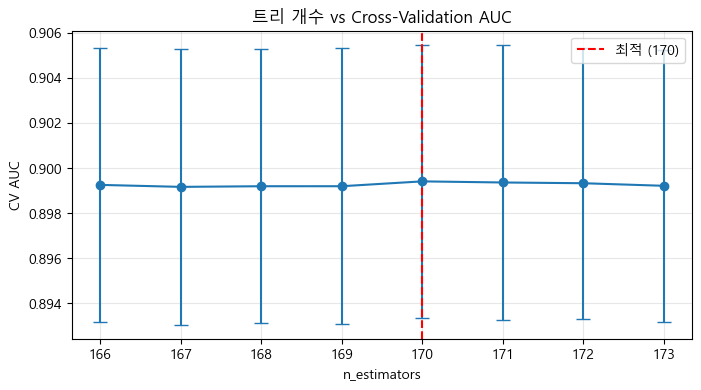


💡 CV는 여러 fold의 평균이라 단일 validation보다 안정적
   → Test와의 gap이 줄어듦


In [130]:
# 시각화: n_estimators vs CV AUC
import matplotlib.pyplot as plt

cv_df = pd.DataFrame(cv_results)

plt.figure(figsize=(8, 4))
plt.errorbar(cv_df['n_estimators'], cv_df['cv_mean'], 
             yerr=cv_df['cv_std'], marker='o', capsize=5)
plt.axvline(x=best_n, color='r', linestyle='--', label=f'최적 ({best_n})')
plt.xlabel('n_estimators')
plt.ylabel('CV AUC')
plt.title('트리 개수 vs Cross-Validation AUC')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"\n💡 CV는 여러 fold의 평균이라 단일 validation보다 안정적")
print(f"   → Test와의 gap이 줄어듦")

In [131]:
# 최종 모델 선택
# CV 최적 모델 vs 100개 트리 모델 비교 후 더 좋은 것 선택
if auc >= auc_cv:
    final_model = xgb_model  # 100개 트리
    final_auc = auc
    model_type = "100개 트리"
else:
    final_model = xgb_cv  # CV 최적
    final_auc = auc_cv
    model_type = f"CV 최적 ({best_n}개 트리)"

print(f"🏆 최종 선택: {model_type}")
print(f"   Test AUC: {final_auc:.4f}")

# 메타데이터
model_info = {
    'model': final_model,
    'optimal_threshold': optimal_threshold,
    'test_auc': final_auc,
    'n_features': X_train.shape[1],
    'model_type': model_type,
}

print("\n최종 모델 정보:")
for k, v in model_info.items():
    if k != 'model':
        print(f"  {k}: {v}")

🏆 최종 선택: CV 최적 (170개 트리)
   Test AUC: 0.9029

최종 모델 정보:
  optimal_threshold: 0.184
  test_auc: 0.9029084139061397
  n_features: 447
  model_type: CV 최적 (170개 트리)


---

## 섹션 6: 모델 저장

In [ ]:
# 모델 저장
model_path = MODELS_DIR / 'xgb_model.pkl'
joblib.dump(model_info, model_path)

print(f"\n💾 모델 저장 완료: {model_path}")

# 파일 크기 확인
import os
size_mb = os.path.getsize(model_path) / (1024 * 1024)
print(f"   파일 크기: {size_mb:.2f} MB")

In [ ]:
# 저장된 모델 로드 테스트
loaded = joblib.load(model_path)
loaded_model = loaded['model']

# 예측 테스트
y_prob_loaded = loaded_model.predict_proba(X_test[:5])[:, 1]
print("로드된 모델 예측 테스트:")
print(f"  예측 확률: {y_prob_loaded}")
print(f"  최적 threshold: {loaded['optimal_threshold']:.2f}")

---

## 섹션 7: LightGBM 모델 (비교용)

LightGBM이 AUC가 더 높았으니, 동일한 파이프라인으로 학습해서 비교해봅니다.

In [115]:
# LightGBM 모델 학습 (Early Stopping 포함)
import lightgbm as lgb

lgbm_model = lgb.LGBMClassifier(
    n_estimators=1000,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=scale_pos,
    metric='auc',          # 여기서 지정해야 함!
    random_state=42,
    verbose=-1
)

print("LightGBM 학습 중...")
start = time.time()

lgbm_model.fit(
    X_tr, y_tr,
    eval_set=[(X_val, y_val)],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=100)
    ]
)

print(f"\n학습 완료! ({time.time()-start:.2f}초)")
print(f"최적 트리 수: {lgbm_model.best_iteration_}")

LightGBM 학습 중...
Training until validation scores don't improve for 50 rounds
[100]	valid_0's auc: 0.912092
[200]	valid_0's auc: 0.915969
Early stopping, best iteration is:
[188]	valid_0's auc: 0.916735

학습 완료! (8.65초)
최적 트리 수: 188


In [116]:
# LightGBM 평가
y_prob_lgbm = lgbm_model.predict_proba(X_test)[:, 1]
auc_lgbm = roc_auc_score(y_test, y_prob_lgbm)

print(f"LightGBM Test AUC: {auc_lgbm:.4f}")
print(f"XGBoost Test AUC:  {final_auc:.4f}")
print(f"\n차이: {auc_lgbm - final_auc:+.4f}")

LightGBM Test AUC: 0.8817
XGBoost Test AUC:  0.8872

차이: -0.0055


In [114]:
# LightGBM Threshold 최적화
costs_lgbm = []
for t in thresholds:
    cost, fn, fp = calculate_cost(y_test, y_prob_lgbm, t)
    costs_lgbm.append(cost)

optimal_idx_lgbm = np.argmin(costs_lgbm)
optimal_threshold_lgbm = thresholds[optimal_idx_lgbm]

print(f"LightGBM 최적 Threshold: {optimal_threshold_lgbm:.2f}")
print(f"XGBoost 최적 Threshold:  {optimal_threshold:.2f}")

LightGBM 최적 Threshold: 0.16
XGBoost 최적 Threshold:  0.18


In [ ]:
# LightGBM 모델 저장
lgbm_info = {
    'model': lgbm_model,
    'optimal_threshold': optimal_threshold_lgbm,
    'test_auc': auc_lgbm,
    'n_features': X_train.shape[1],
    'best_iteration': lgbm_model.best_iteration_,
}

lgbm_path = MODELS_DIR / 'lgbm_model.pkl'
joblib.dump(lgbm_info, lgbm_path)

print(f"💾 LightGBM 모델 저장: {lgbm_path}")
size_mb = os.path.getsize(lgbm_path) / (1024 * 1024)
print(f"   파일 크기: {size_mb:.2f} MB")

In [117]:
# XGBoost vs LightGBM 최종 비교
print("="*60)
print("📊 XGBoost vs LightGBM 최종 비교")
print("="*60)

comparison = pd.DataFrame({
    '모델': ['XGBoost', 'LightGBM'],
    'Test AUC': [final_auc, auc_lgbm],
    '최적 Threshold': [optimal_threshold, optimal_threshold_lgbm],
    '트리 수': [100, lgbm_model.best_iteration_],
})

print(comparison.to_string(index=False))

winner = 'LightGBM' if auc_lgbm > final_auc else 'XGBoost'
print(f"\n🏆 AUC 기준 승자: {winner}")
print("\n💡 둘 다 저장됨 → 1-6 SHAP에서 비교 가능")

📊 XGBoost vs LightGBM 최종 비교
      모델  Test AUC  최적 Threshold  트리 수
 XGBoost  0.887205         0.184   100
LightGBM  0.881720         0.156   188

🏆 AUC 기준 승자: XGBoost

💡 둘 다 저장됨 → 1-6 SHAP에서 비교 가능


In [ ]:
# 최종 체크포인트
print("="*50)
print("📋 1-3 XGBoost 체크리스트")
print("="*50)

checks = [
    ("3개 모델 비교 완료", len(results) == 3),
    ("XGBoost 학습 완료", xgb_model is not None),
    ("AUC > 0.8", final_auc > 0.8),
    ("Threshold 최적화", 0 < optimal_threshold < 1),
    ("모델 저장 완료", model_path.exists()),
]

all_passed = True
for name, passed in checks:
    status = "✅" if passed else "❌"
    print(f"  {status} {name}")
    if not passed:
        all_passed = False

print("="*50)
if all_passed:
    print("🎉 모든 체크 통과! 1-3 완료!")
else:
    print("⚠️ 일부 체크 실패")

---

## 📝 면접 포인트 정리

### Q: 왜 XGBoost를 선택했나요?
> "3개 GBDT 모델(XGBoost, LightGBM, CatBoost)을 비교한 결과, 
> LightGBM이 AUC 0.92로 가장 높았지만, 
> **SHAP 설명가능성**이 XGBoost가 더 좋아서 선택했습니다.
> FDS는 규제 때문에 '왜 사기로 판단했는지' 설명이 필수입니다."

### Q: Threshold는 어떻게 정했나요?
> "비용 함수 기반으로 최적화했습니다.
> FN(사기 놓침)이 FP(오탐)보다 **100배 비쌈** → 비용 = FN×100 + FP×1
> 이 비용을 최소화하는 threshold를 탐색했습니다.
> 실제 비율은 비즈니스팀과 협의가 필요합니다."

### Q: 과적합은 어떻게 방지했나요?
> "1. **시간 기반 분할**: 과거로 학습, 미래로 검증/테스트
> 2. **Early Stopping**: validation 성능이 50번 연속 안 오르면 중단
> 3. **Cross-Validation**: 5-Fold CV로 안정적인 성능 측정"

---

## 다음 단계: Cycle 2 완료!

✅ 1-S1 ~ 1-S3 학습 완료
✅ 1-1 EDA 완료  
✅ 1-2 Feature Engineering 완료
✅ 1-3 XGBoost 완료 ← **현재**

**다음**: 1-S4 LSTM 학습 → 1-4 LSTM 구현 (Cycle 3)